In [59]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [218]:
class NN_LinearGrid():
    def __init__(self, values, binning):
        """
        values  : tensor-like with shape (ax1_n_bin, ..., axd_n_bin)
        binning : [
            [ax1_lower, ax1_upper, ax1_n_bin], 
            ...,
            [axd_lower, axd_upper, axd_n_bin], 
            ]
        """
        self.ref_values = tf.convert_to_tensor(values, dtype=tf.float32)
        self.binning = binning
        self.dim = len(binning)
        
        self.lowers = tf.constant([axis[0] for axis in binning], dtype=tf.float32)
        self.stepsize = tf.constant([(axis[1]-axis[0])/(axis[2]-1) for axis in binning], dtype=tf.float32)
        self.num_bins = tf.constant([(axis[2]-1) for axis in binning], dtype=tf.int32)
        self.lowers = tf.reshape(self.lowers, (1, 1, self.dim))
        self.stepsize = tf.reshape(self.stepsize, (1, 1, self.dim))
        self.num_bins = tf.reshape(self.num_bins, (1, 1, self.dim))
        
        self._magic_ind_shift = tf.transpose(tf.constant([([1]*(2**i)+[0]*(2**i))*(2**(self.dim-i-1)) for i in range(self.dim)], dtype=tf.int32))
        self._magic_ind_shift = tf.expand_dims(self._magic_ind_shift, axis=1)
        
        assert len(binning) == len(tf.shape(values)), "binning (%i-D) must have the same dimension as values (%i-D)!"%(len(binning), len(tf.shape(values)))
        assert tf.reduce_all(tf.shape(values) == [axis[2] for axis in binning]), "values shape is not consistent with binning!"
    
    def __call__(self, *args, **kwargs):
        return self.interp(*args, **kwargs)
    
    def _get_nn_indices(self, points):
        """
        points : (1, N, D)
        return : (2^D, N, D)
        """
        ind = tf.clip_by_value(tf.cast((points - self.lowers) / self.stepsize, tf.int32), 0, self.num_bins-1)
        return ind + self._magic_ind_shift
    
    
    def interp(self, points):
        """
        points : (N, D)
        return : (N, )
        """
        points = tf.convert_to_tensor(points, dtype=tf.float32)
        
        points = tf.expand_dims(points, axis=0)
        ind = self._get_nn_indices(points)
        ref_pos = self.lowers + self.stepsize * tf.cast(ind, tf.float32)
        dr2 = tf.reduce_sum(tf.square(points - ref_pos), axis=-1)
        weights = 1. / tf.clip_by_value(tf.sqrt(dr2), 1e-6, float('inf'))
        vals = tf.gather_nd(self.ref_values, ind)
        vals = tf.math.reduce_sum(vals * weights, axis=0) / tf.math.reduce_sum(weights, axis=0)
        return vals

In [219]:
def f(x, y):
    return np.sin(2*x) * np.cos(0.5*y)

In [220]:
xx = np.linspace(-5, 5, 100)
yy = np.linspace(-5, 5, 50)
binning = [
    [-5, 5, 100],
    [-5, 5, 50]
]
xx, yy = np.meshgrid(xx, yy)
zz = f(xx, yy)

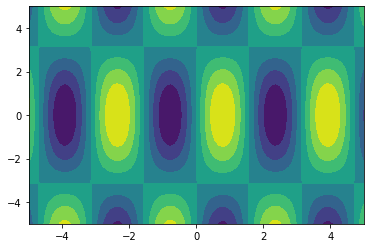

In [221]:
plt.contourf(xx, yy, zz)

In [222]:
itpf = NN_LinearGrid(np.transpose(zz), binning)

In [223]:
x = np.random.uniform(-6, 6, 10000)
y = np.random.uniform(-6, 6, 10000)

z =itpf(np.transpose([x, y]))

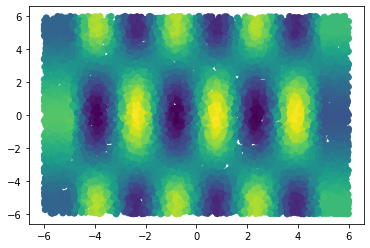

In [224]:
plt.scatter(x, y, c=z)

In [229]:
if tf.reduce_all(tf.shape(zz) != [50, 100]):
    print(1)